### Import necessary libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2025-01-11 19:21:01.561387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 19:21:01.561430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 19:21:01.561482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 19:21:01.570248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Variables

In [2]:
classes = 43

### Create model

In [3]:
def create_model(learning_rate=0.0001):
    
    base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
    )
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(43, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = keras.optimizers.Adam(learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


### Resize all images to 32x32 pixels

In [4]:
def resize_images(size=(32, 32)):
    for i in range(classes):
        input_directory = f"../app/data/train/{i}"
        output_directory = f"../app/data/train-r/{i}"
        
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
    
        for filename in os.listdir(input_directory):
            input_path = os.path.join(input_directory, filename)
            output_path = os.path.join(output_directory, filename)
    
            try:
                with Image.open(input_path) as img:
                    img = img.resize(size)
                    img.save(output_path)
                    print(f"Resized and saved: {output_path}")
            except Exception as e:
                print(f"Error processing {input_path}: {e}")

In [ ]:
resize_images(size=(32, 32))

### Load train images

In [6]:
def load_images():
    
    sign_images = []
    sign_indexes = []

    for i in range(classes):
        
        input_directory = f"../app/data/train-r/{i}"
        
        for filename in os.listdir(input_directory):
            input_path = os.path.join(input_directory, filename)

            try:
                with Image.open(input_path) as img:
                    sign_images.append(np.array(img))
                    sign_indexes.append(i)
            except Exception as e:
                print(f"Error processing {input_path}: {e}")

    sign_images = np.array(sign_images)
    sign_indexes = np.array(sign_indexes)

    return sign_images, sign_indexes

In [7]:
sign_images, sign_indexes = load_images()

### Split train images

In [8]:
X_train, X_val, y_train, y_val = train_test_split(sign_images, sign_indexes, test_size=0.2, random_state=42)

In [9]:
y_train = keras.utils.to_categorical(y_train, classes)
y_val = keras.utils.to_categorical(y_val, classes)

In [26]:
sign_images.shape, sign_indexes.shape

((39209, 32, 32, 3), (39209,))

In [27]:
X_train.shape, X_val.shape

((31367, 32, 32, 3), (7842, 32, 32, 3))

In [28]:
y_train.shape, y_val.shape

((31367, 43), (7842, 43))

### Train model

The model was trained for different **learning rate** values. Below you can see the **valuation accuracy** achieved for each **learning rate** value:

| Learning rate      | 0.1  | 0.01 | 0.001 | 0.0001 |
| :-------------------| :---- | :---- | :----- | :------ |
| Valuation accuracy | 0.06 | 0.12 | 0.85  | 0.91   |

We can see that for learning rate value of **0.0001** we have the best accuracy of **0.91**

In [18]:
model = create_model(learning_rate=0.0001)

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint (
    "./checkpoints/traffic_sign_classification_resnet50_lr0001_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy"
)

history = model.fit(X_train,y_train,
                    validation_data=(X_val, y_val),
                    epochs=35, batch_size=32, 
                    callbacks=[checkpoint])

Epoch 1/35
981/981 [==============================] - 19s 16ms/step - loss: 2.9909 - accuracy: 0.2602 - val_loss: 1.8014 - val_accuracy: 0.4779
Epoch 2/35
981/981 [==============================] - 14s 14ms/step - loss: 1.9508 - accuracy: 0.4200 - val_loss: 1.4059 - val_accuracy: 0.5618
Epoch 3/35
981/981 [==============================] - 14s 14ms/step - loss: 1.5889 - accuracy: 0.5025 - val_loss: 1.1649 - val_accuracy: 0.6456
Epoch 4/35
981/981 [==============================] - 14s 15ms/step - loss: 1.3675 - accuracy: 0.5667 - val_loss: 1.0024 - val_accuracy: 0.6889
Epoch 5/35
981/981 [==============================] - 14s 15ms/step - loss: 1.1882 - accuracy: 0.6149 - val_loss: 0.8780 - val_accuracy: 0.7334
Epoch 6/35
981/981 [==============================] - 14s 14ms/step - loss: 1.0565 - accuracy: 0.6558 - val_loss: 0.7838 - val_accuracy: 0.7485
Epoch 7/35
981/981 [==============================] - 14s 14ms/step - loss: 0.9438 - accuracy: 0.6924 - val_loss: 0.7041 - val_accuracy:

### Plot accuracy and loss

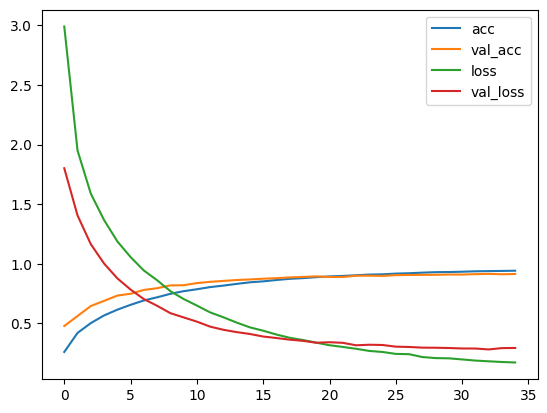

In [20]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In this graph we can see that that **accuracy** and **val_accuracy** values are rising and at the same time **loss** and **val_loss** values are decreasing.

### Make predictions

In [21]:
class_descriptions = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric'
}

In [22]:
image = '../app/data/test/00001.png'

In [23]:
def make_prediction(image):
    # Load model
    # You can select the file you want from the checkpoints folder
    model = keras.models.load_model('./checkpoints/traffic_sign_classification_resnet50_lr0001_33_0.915.h5')
    
    # Load image
    try:
        img = Image.open(image)
        img = img.resize((32,32))
        
    except Exception as e:
        print(f"Error processing {input_path}: {e}")


    # Create image matrix
    x = np.array(img)
    X = np.array([x])
    print(type(x))
    print(X.shape)
    
    # Make prediction
    pred = model.predict(X)

    # Get class info
    class_index = pred[0].argmax()
    class_name = class_descriptions[class_index]

    # Return info
    return class_index, class_name

In [24]:
class_index, class_name = make_prediction(image)

<class 'numpy.ndarray'>
(1, 32, 32, 3)
1/1 [==============================] - 1s 1s/step


In [25]:
class_index, class_name

(1, 'Speed limit (30km/h)')